# Inputs

In [1]:
import os 
import pandas as pd 
from bs4 import BeautifulSoup
import base64


PATH_BASE = './project-dp-trend-description/'
url_paths = os.listdir(PATH_BASE)
htmls_encoded = []
for file in url_paths: 
    html64file = pd.read_csv(PATH_BASE + file, nrows=500)
    htmls_encoded += html64file['html'].to_list()


pages = []
for html in htmls_encoded: 
    content = base64.b64decode(html)
    soup = BeautifulSoup(content, 'html.parser')
    text_elems = soup.find_all()[0]
    pages.append(text_elems)
    
    

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


# Finding the Target Labels 

### modification: train data should only contain the two inner most layers of DOM tree

In [2]:
def find_target_element(page): 
    try:
        og_description = page.head.find("meta", {"property": "og:description"})['content']
        element = page.body.find(string=og_description).parent 
        return element
    except: 
        return None

pages_targets = [find_target_element(page) for page in pages] # finding the target element of each page
pages, pages_targets = zip(*[(p,t) for p,t in zip(pages, pages_targets) if t is not None]) # Some pages were just 403 Errors, which yielded no og:description


In [3]:
pages = [pages[i].body.find_all()[1:] for i in range(len(pages))] # casting the pages from a tag ogject to a list of elements

# Create Feature Vectors

In [4]:
import re
import hazm

def length_without_spaces(elem):
    return len(elem.text.strip().replace(" ", ""))

def ratio_of_spaces(elem):
    return len(elem.text.strip().replace(" ", "")) / (len(elem.text.strip()) + 1)

def word_count(elem):
    return len(re.findall(r'\b\w+\b', elem.text))

def depth(elem):
    depth = 0
    while elem.parent is not None:
        depth += 1
        elem = elem.parent
    return depth

def sibling_count(elem):
    return len(elem.find_previous_siblings()) + len(elem.find_next_siblings())

def child_count(elem):
    return len(list(elem.children))

def attribute_count(elem):
    attributes = elem.attrs
    return len(attributes)

def class_count(elem):
    return len(elem['class']) if elem.has_attr('class') else 0

def elem_type(elem):
    if elem.name == "div":
        return 0
    elif elem.name == "p":
        return 1
    elif elem.name == "span":
        return 2
    else:
        return 3

def persian_stopword_ratio_hazm(elem):
    normalizer = hazm.Normalizer()
    stemmer = hazm.Stemmer()
    stops = hazm.stopwords_list()
    text = elem.get_text()
    normalized_text = normalizer.normalize(text)
    words = re.findall(r'\b\w+\b', normalized_text)
    persian_words = [stemmer.stem(word) for word in words if re.search(r'[\u0600-\u06FF]+', word)]
    persian_stopwords = [word for word in persian_words if word in stops]
    return len(persian_stopwords) / len(persian_words) if persian_words else 0


def persian_verb_ratio(elem):
    normalizer = hazm.Normalizer()
    tagger = hazm.POSTagger(model='resources/postagger.model')
    text = elem.get_text()
    normalized_text = normalizer.normalize(text)
    words = re.findall(r'\b\w+\b', normalized_text)
    persian_verbs = [word for word, tag in tagger.tag(words) if tag.startswith('V')]
    return len(persian_verbs) / len(words) if words else None


def create_feature_vector(elem, full=False):
    results = []
    results.append(length_without_spaces(elem))
    results.append(ratio_of_spaces(elem))
    results.append(word_count(elem))
    results.append(depth(elem))
    results.append(sibling_count(elem))
    results.append(child_count(elem))
    results.append(attribute_count(elem))
    results.append(class_count(elem))
    results.append(elem_type(elem))
    if full: 
        results.append(persian_stopword_ratio_hazm(elem))
        results.append(persian_verb_ratio(elem))
    return results



In [5]:
def create_flattened_feature_vector(pages):
    """
    Apply create_feature_vector to every element in every page and store all results in a flattened array.

    :param pages: A list of pages, where each page is a list of elements
    :return: A flattened array of feature vectors
    """

    flattened_features = []
    for page in pages:
        for element in page:
            flattened_features.append(create_feature_vector(element))

    return flattened_features

non_target_features = create_flattened_feature_vector(pages)
target_features = create_flattened_feature_vector([pages_targets])

In [6]:
import pandas as pd
col_names = ['length_without_spaces', 'ratio_of_spaces', 'word_count', 
             'depth', 'sibling_count', 'child_count', 
             'attribute_count', 'class_count', 'elem_type']

df_normal = pd.DataFrame(non_target_features, columns=col_names)
df_target = pd.DataFrame(target_features, columns=col_names)

In [20]:
SIZE = len(df_target)
X = pd.concat([df_normal.sample(SIZE), df_target], axis=0)
X['y'] = [0 if x<SIZE else 1 for x in range(SIZE*2)]
X = X.sample(frac=1)
y = X.pop('y')

Acc of Test: 10k mixed classes: 0.9881516587677726


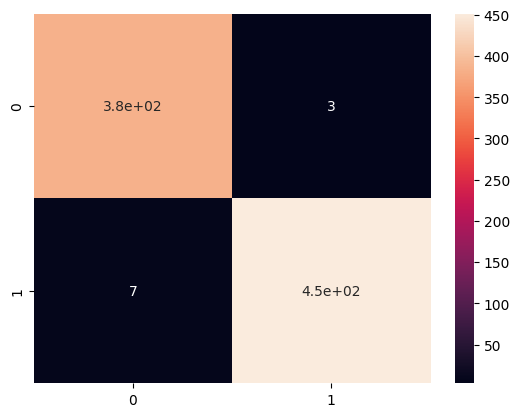

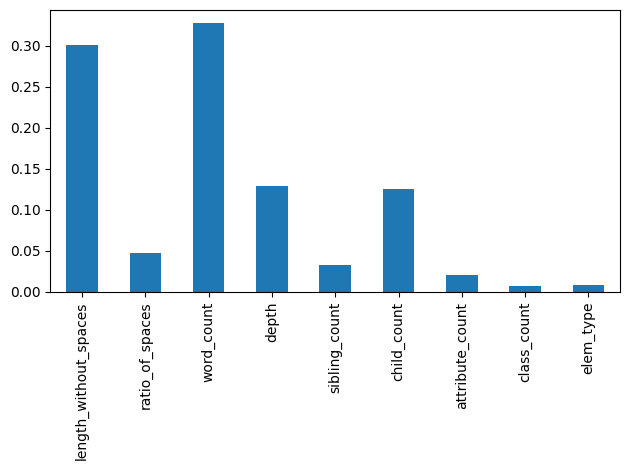

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = RandomForestClassifier(max_depth=9, random_state=0)
clf.fit(X_train, y_train)
print('Acc of Test: 10k mixed classes: ' + str(clf.score(X_test, y_test))) #test

cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
sns.heatmap(cm, annot=True)
plt.show() 

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=col_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, )#yerr=std, )
fig.tight_layout()

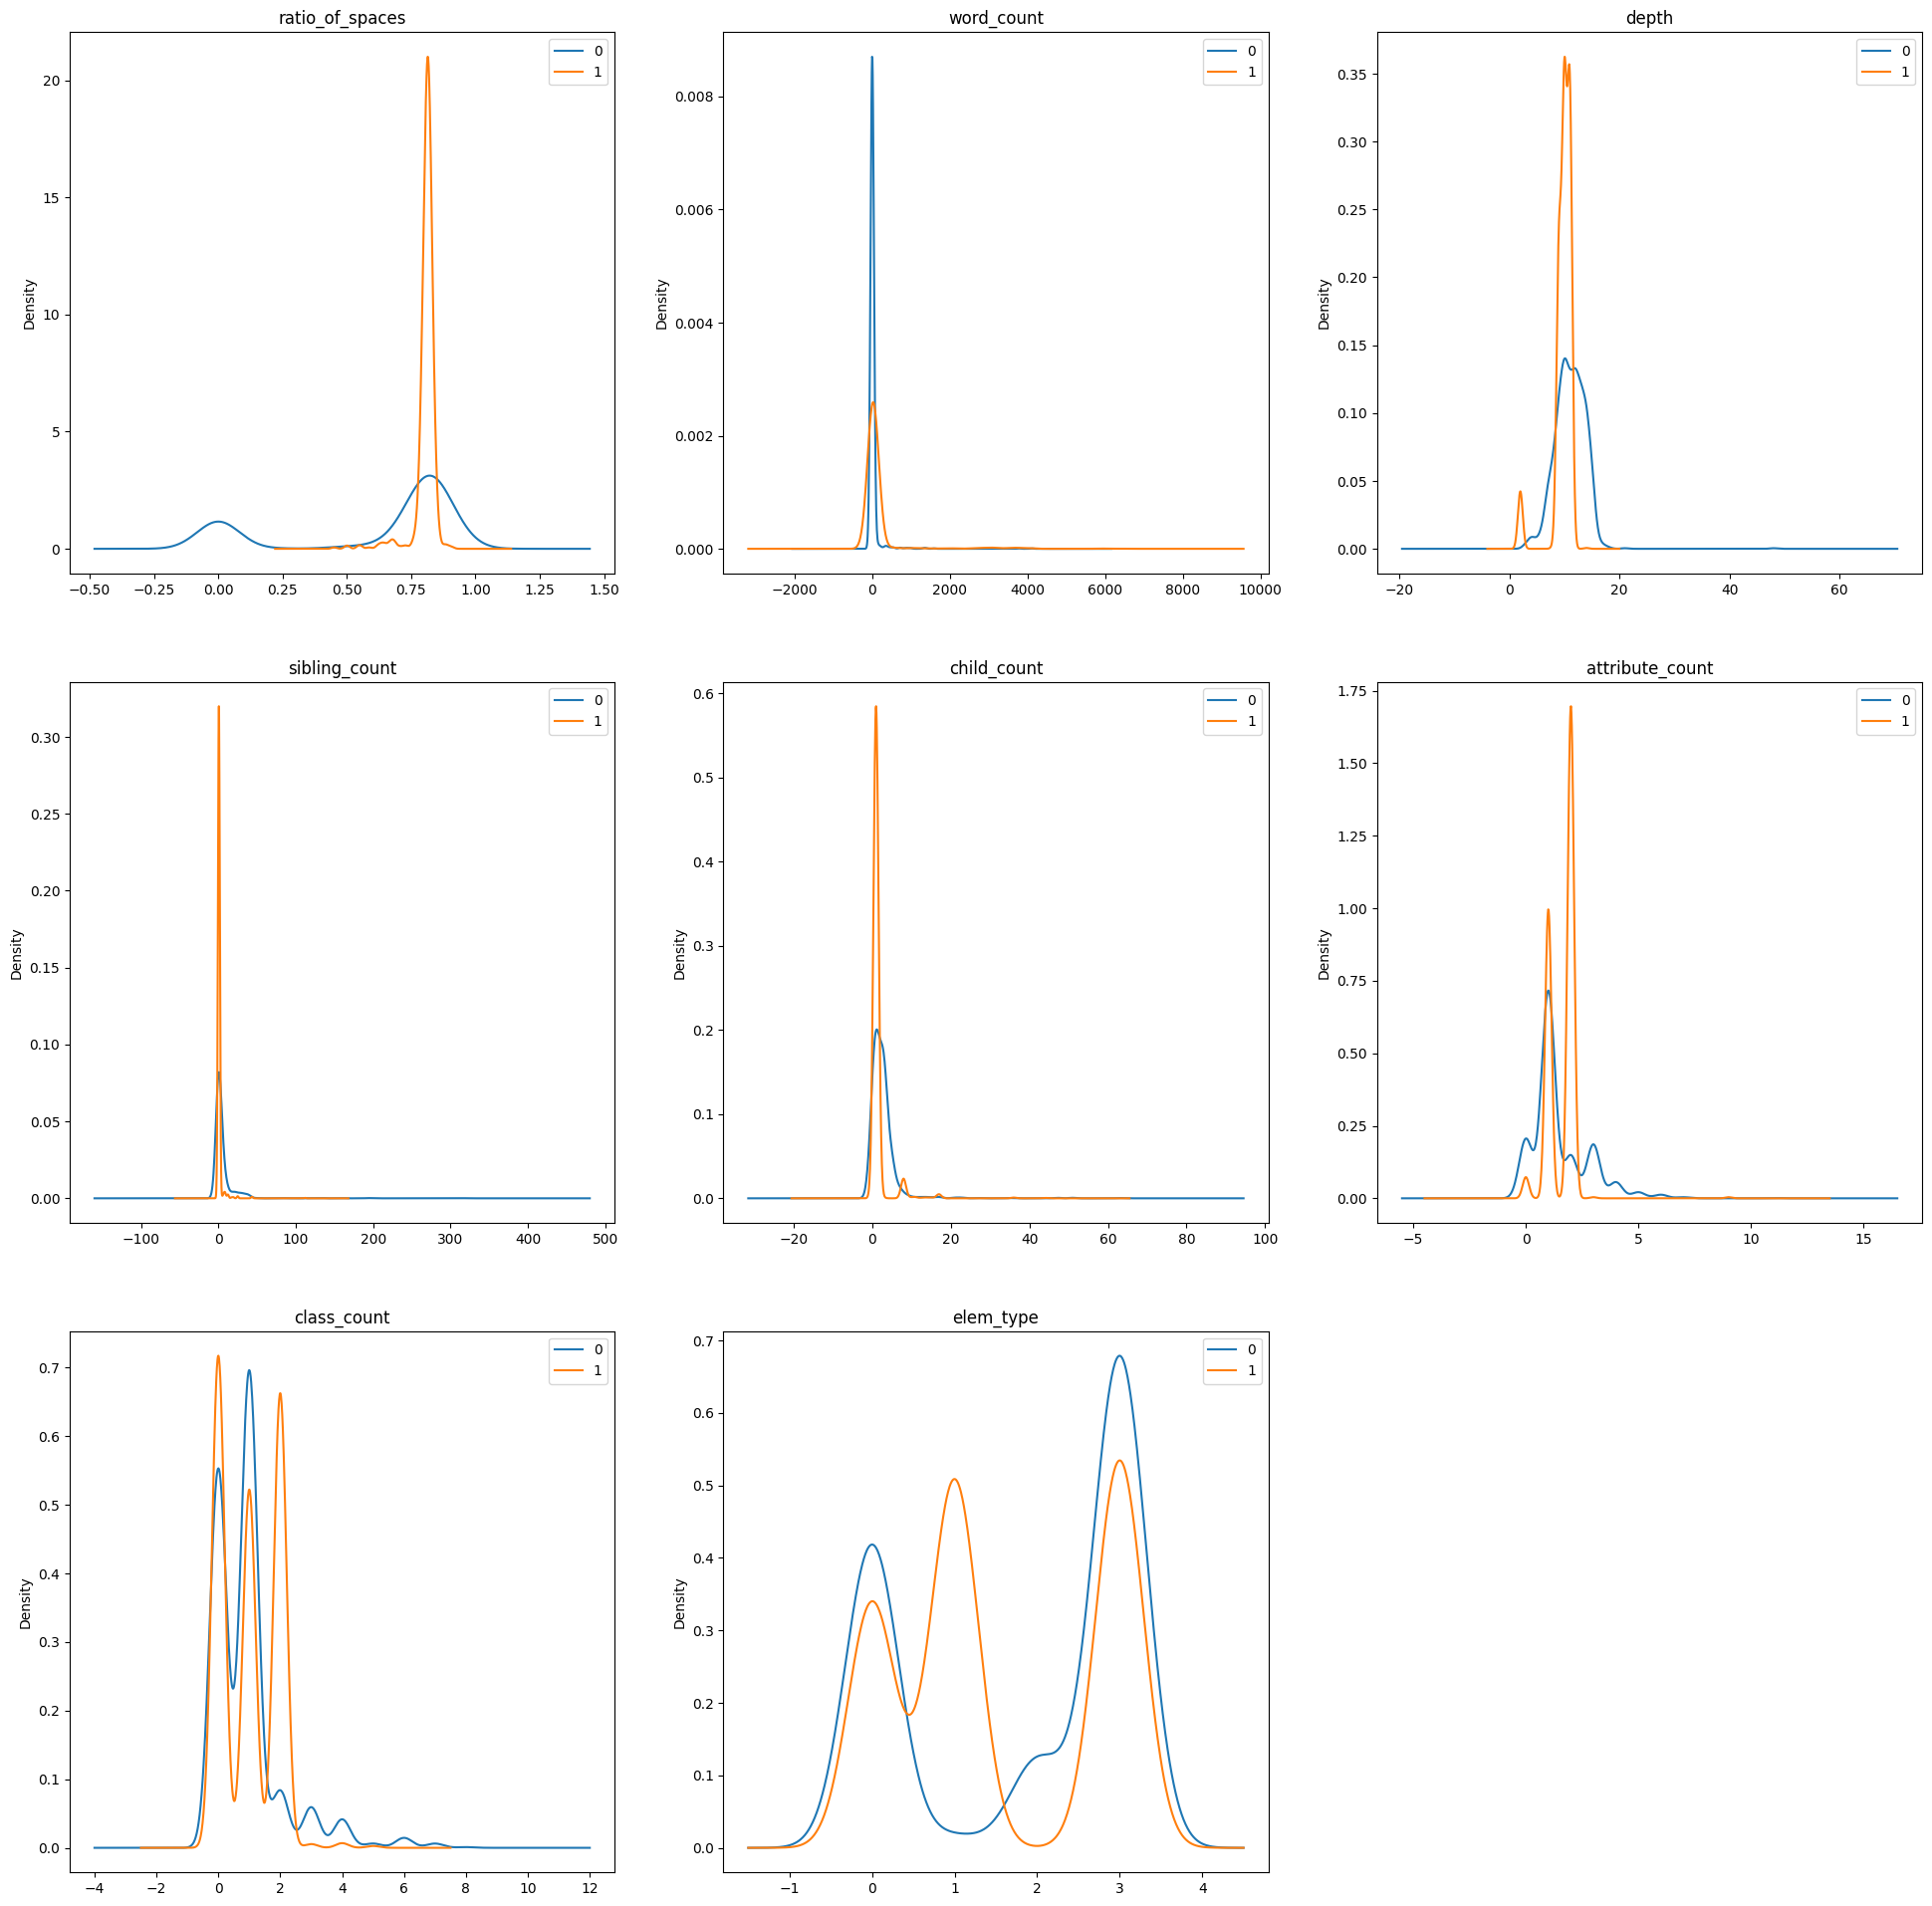

In [9]:
X['y'] = y
plt.figure(figsize=(24, 24))
xg = X.groupby('y')
for i in range(1, len(col_names)):
    plt.subplot(3, 3, i)
    xg[f'{col_names[i]}'].plot(kind='kde'); plt.title(col_names[i]); plt.legend()

Acc of Test: 10k mixed classes: 0.9609004739336493


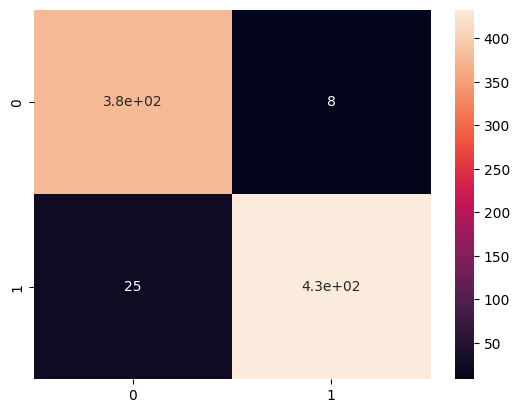

In [26]:
from sklearn.svm import SVC

clf = SVC(gamma='auto').fit(X_train, y_train)
print('Acc of Test: 10k mixed classes: ' + str(clf.score(X_test, y_test))) #test
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
sns.heatmap(cm, annot=True)
plt.show() 

In [27]:
import requests


#url = 'https://www.msn.com/en-ae/news/other/how-china-interacts-with-ukraine-war-will-determine-eu-ties/ar-AA19gXsG?ocid=msedgntp&cvid=ae40389b81ae41f69ffc42bad6f94dde&ei=15'
url = 'https://labsnet.ir/news/69805/%D8%AF%D8%B3%D8%AA%D8%A7%D9%88%D8%B1%D8%AF%D9%87%D8%A7%DB%8C-%D9%81%D9%86%D8%A7%D9%88%D8%B1%D8%A7%D9%86%D9%87-%D8%AF%D8%B1-%D8%AD%D9%88%D8%B2%D9%87-%D8%AA%D8%AC%D9%87%DB%8C%D8%B2%D8%A7%D8%AA-%D9%88-%D9%85%D9%88%D8%A7%D8%AF-%D8%A2%D8%B2%D9%85%D8%A7%DB%8C%D8%B4%DA%AF%D8%A7%D9%87%DB%8C'
url = 'https://vigiato.net/p/374915'
url = 'https://labsnet.ir/news/69851/%D8%AF%D9%88%D8%B1%D9%87-%D8%A2%D9%85%D9%88%D8%B2%D8%B4%DB%8C-%D8%AF%D8%A7%D8%B1%D8%A8%D8%B3%D8%AA-%D9%87%D8%A7%DB%8C-%D9%85%D9%87%D9%86%D8%AF%D8%B3%DB%8C-%D8%A8%D8%A7%D9%81%D8%AA-%D9%88-%DA%A9%D8%B4%D8%AA-%D8%B3%D9%84%D9%88%D9%84-%D8%A8%D8%B1%DA%AF%D8%B2%D8%A7%D8%B1-%D9%85%DB%8C-%D8%B4%D9%88%D8%AF'

req = requests.get(url)
soup_test = BeautifulSoup(req.content, 'html.parser')
elems_test = soup_test.body.find_all(['p', 'div', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'span', 'strong'])[1:]
df_test = create_flattened_feature_vector([elems_test])
preds = clf.predict(pd.DataFrame(df_test, columns=col_names))


for i in range(len(preds)): 
    if preds[i] == 1:   
        print(elems_test[i])

<p>دوره آموزشی تئوری عملی داربست های مهندسی بافت و کشت سلول پژوهشکده پوشش‌های نانوساختار با همکاری پژوهشکده علوم تولیدمثل یزد برگزار می‌شود.</p>
<p style="color:#b3b3b3;">کلیه حقوق این سایت متعلق به معاونت علمی و فناوری ریاست جمهوری است.</p>
